## Generation of Weight Matrices

In [1]:
import os
import re
import numpy as np
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime
import seaborn as sns
import networkx as nx
from sklearn.cluster import KMeans

# For Ray Tune and TensorBoard logging
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

#############################################
#  CREATE FOLDERS & UTILITY FUNCTIONS
#############################################

def create_directory(dir_path):
    """Create directory if it does not exist."""
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def rescale_matrix(W, desired_radius):
    """
    Rescale the matrix W to have the desired spectral radius.
    
    Returns:
        W_rescaled: The rescaled matrix,
        current_radius: The original spectral radius,
        scaling_factor: The factor applied.
    """
    eigenvalues = torch.linalg.eigvals(W)
    current_radius = eigenvalues.abs().max().item()
    scaling_factor = desired_radius / current_radius if current_radius != 0 else 1.0
    W_rescaled = W * scaling_factor
    return W_rescaled, current_radius, scaling_factor

#############################################
#  BASIC HISTOGRAM PLOTS (Matplotlib & Plotly)
#############################################

def plot_and_save_histogram(matrix, title, save_path, bins=50):
    """Plot and save a static (PNG) histogram of matrix values using Matplotlib."""
    plt.figure()
    plt.hist(matrix.flatten(), bins=bins, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Weight Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_and_save_interactive_histogram(matrix, title, save_path, bins=50):
    """Plot and save an interactive (HTML) histogram of matrix values using Plotly."""
    data = matrix.flatten()
    fig = px.histogram(data, nbins=bins, title=title,
                       labels={'value': 'Weight Value', 'count': 'Frequency'})
    fig.write_html(save_path)

#############################################
#  ADDITIONAL VISUALIZATION FUNCTIONS
#############################################

def plot_sorted_bar(matrix, title, save_path):
    """Plot a sorted bar plot of all weights."""
    flat = np.sort(matrix.flatten())
    plt.figure(figsize=(10, 4), dpi=300)
    plt.bar(range(len(flat)), flat, color='mediumpurple')
    plt.title(title)
    plt.xlabel('Sorted Index')
    plt.ylabel('Weight Value')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_violin(matrix, title, save_path):
    """Plot a violin plot of weight values using Seaborn."""
    flat = matrix.flatten()
    plt.figure(figsize=(6, 4), dpi=300)
    # Use fill=True to avoid FutureWarning
    sns.violinplot(data=flat, color='lightgreen')
    plt.title(title)
    plt.xlabel('Weights')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_kde(matrix, title, save_path):
    """Plot a KDE of the weight distribution using Seaborn. 
       If variance is 0, plot a flat line instead."""
    flat = matrix.flatten()
    plt.figure(figsize=(6, 4), dpi=300)
    if np.var(flat) == 0:
        # Plot a flat density line
        plt.plot([flat[0], flat[0]], [0, 1], color='teal')
        plt.title(title + "\n(Data has zero variance)")
        plt.xlabel('Weight Value')
        plt.ylabel('Density')
    else:
        sns.kdeplot(flat, fill=True, color='teal', warn_singular=False)
        plt.title(title)
        plt.xlabel('Weight Value')
        plt.ylabel('Density')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_adjacency_graph(matrix, title, save_path, threshold=0.01):
    """
    For sparse matrices: plot an adjacency graph.
    Only edges with weight above 'threshold' are drawn.
    """
    G = nx.from_numpy_array(matrix, create_using=nx.DiGraph())
    G.remove_edges_from([(u, v) for u, v, w in G.edges(data='weight') if abs(w) < threshold])
    plt.figure(figsize=(8, 6), dpi=300)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray')
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_clustered_heatmap(matrix, title, save_path, n_clusters=4):
    """
    Cluster rows of the matrix using KMeans and plot a clustered heatmap.
    If the number of unique rows is less than n_clusters, reduce n_clusters.
    """
    unique_rows = np.unique(matrix, axis=0)
    effective_clusters = min(n_clusters, len(unique_rows))
    kmeans = KMeans(n_clusters=effective_clusters, random_state=42).fit(matrix)
    idx = np.argsort(kmeans.labels_)
    clustered_matrix = matrix[idx, :]
    plt.figure(figsize=(8, 6), dpi=300)
    sns.heatmap(clustered_matrix, cmap='viridis')
    plt.title(title)
    plt.xlabel('Columns')
    plt.ylabel('Rows (clustered)')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

#############################################
#  ADVANCED VISUALIZATIONS (Heatmaps & 3D Surfaces)
#############################################

def plot_heatmap_matplotlib(W, title, save_path, interpolation='bicubic', cmap='viridis'):
    """
    Plot a 2D heatmap of the weight matrix W using Matplotlib.
    Saves a static PNG file.
    """
    plt.figure(figsize=(8, 6), dpi=300)
    plt.imshow(W, cmap=cmap, interpolation=interpolation, aspect='auto')
    plt.title(title)
    plt.colorbar(label='Weight Value')
    plt.xlabel('Post-Synaptic Neuron Index')
    plt.ylabel('Pre-Synaptic Neuron Index')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_heatmap_plotly(W, title, save_path):
    """
    Plot an interactive 2D heatmap of the weight matrix W using Plotly.
    Saves an HTML file.
    """
    fig = go.Figure(data=go.Heatmap(
        z=W,
        colorscale='Viridis',
        colorbar=dict(title='Weight Value')
    ))
    fig.update_layout(
        title=title,
        xaxis_title="Post-Synaptic Index",
        yaxis_title="Pre-Synaptic Index"
    )
    fig.write_html(save_path)

def plot_3d_surface_matplotlib(W, title, save_path, cmap='viridis'):
    """
    Plot a 3D surface of the weight matrix W using Matplotlib.
    Saves a static PNG file.
    Note: tight_layout() is not used here for 3D plots.
    """
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    rows, cols = W.shape
    X, Y = np.meshgrid(range(cols), range(rows))
    fig = plt.figure(figsize=(8, 6), dpi=300)
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, W, cmap=cmap, edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel("Post-Synaptic Index")
    ax.set_ylabel("Pre-Synaptic Index")
    ax.set_zlabel("Weight Value")
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig(save_path, dpi=300)
    plt.close()

def plot_3d_surface_plotly(W, title, save_path):
    """
    Plot a 3D surface of the weight matrix W using Plotly.
    Saves an HTML file.
    """
    rows, cols = W.shape
    X, Y = np.meshgrid(range(cols), range(rows))
    fig = go.Figure(data=[go.Surface(z=W, x=X, y=Y, colorscale='Viridis')])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='Post-Synaptic Index',
            yaxis_title='Pre-Synaptic Index',
            zaxis_title='Weight Value'
        )
    )
    fig.write_html(save_path)

#############################################
#  HELPER FUNCTION TO LOAD A MATRIX
#############################################

def load_matrix(matrix_path):
    """Load a matrix (stored as a .npy file) from the given path."""
    return np.load(matrix_path)

#############################################
#  MAIN CODE: GENERATE, SAVE & VISUALIZE WEIGHT MATRIX
#############################################

seed = 42
reservoir_size = 100

init_weight_a = -1.0
init_weight_b = 1.0

gaussian_mean = 1.0
gaussian_std = 1.0

desired_radii = [0.1, 0.5, 1.0, 2.0, 10.0]

# Initialization method: "uniform", "gaussian", or "sparse".
initialization_method = "uniform"
sparsity = 0.1  # NOTE: sparsity 0.1 means that 90% of weights are zero

# Set random seeds for reproducibility.
torch.manual_seed(seed)
np.random.seed(seed)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
base_folder = '/home/workspaces/polimikel/UCR/Weight_matrices'
if initialization_method == "sparse":
    sparsity_str = str(sparsity).replace('.', 'x')
    unique_folder_name = f"matrix_seed_{seed}_sparse{sparsity_str}_{timestamp}"
else:
    unique_folder_name = f"matrix_seed_{seed}_{initialization_method}_{timestamp}"
unique_folder_path = os.path.join(base_folder, unique_folder_name)
create_directory(unique_folder_path)

params_file = os.path.join(unique_folder_path, "initialization_params.txt")
with open(params_file, "w") as f:
    f.write("Initialization Parameters:\n")
    f.write(f"Seed: {seed}\n")
    f.write(f"Initialization Method: {initialization_method}\n")
    if initialization_method == "sparse":
        f.write(f"Sparse Density: {sparsity}\n")
    f.write(f"Reservoir Size: {reservoir_size}\n")
    f.write(f"Uniform Boundaries: {init_weight_a} to {init_weight_b}\n")
    if initialization_method == "gaussian":
        f.write(f"Gaussian Parameters: mean={gaussian_mean}, std={gaussian_std}\n")
    f.write(f"Desired Spectral Radii: {desired_radii}\n")
    f.write(f"Timestamp: {timestamp}\n")

W_initial = torch.empty((reservoir_size, reservoir_size))
if initialization_method == "uniform":
    torch.nn.init.uniform_(W_initial, a=init_weight_a, b=init_weight_b)
elif initialization_method == "gaussian":
    torch.nn.init.normal_(W_initial, mean=gaussian_mean, std=gaussian_std)
elif initialization_method == "sparse":
    torch.nn.init.uniform_(W_initial, a=init_weight_a, b=init_weight_b)
    mask = (torch.rand(W_initial.shape) < sparsity).float()
    W_initial = W_initial * mask
else:
    raise ValueError("Invalid initialization method selected. Choose 'uniform', 'gaussian', or 'sparse'.")

original_folder = os.path.join(unique_folder_path, 'original')
create_directory(original_folder)
original_matrix_path = os.path.join(original_folder, 'W_original.npy')
np.save(original_matrix_path, W_initial.numpy())

plot_and_save_histogram(W_initial.numpy(), 'Histogram of Original Connectivity Matrix', 
                          os.path.join(original_folder, 'W_original_hist.png'))
plot_and_save_interactive_histogram(W_initial.numpy(), 'Interactive Histogram of Original Connectivity Matrix', 
                                    os.path.join(original_folder, 'W_original_hist_interactive.html'))

plot_heatmap_matplotlib(W_initial.numpy(), "Original Weight Matrix (Heatmap)", 
                        os.path.join(original_folder, 'W_original_heatmap.png'))
plot_heatmap_plotly(W_initial.numpy(), "Original Weight Matrix (Interactive Heatmap)", 
                    os.path.join(original_folder, 'W_original_heatmap_interactive.html'))
plot_3d_surface_matplotlib(W_initial.numpy(), "Original Weight Matrix (3D Surface)", 
                           os.path.join(original_folder, 'W_original_3Dsurface.png'))
plot_3d_surface_plotly(W_initial.numpy(), "Original Weight Matrix (3D Surface, Interactive)", 
                       os.path.join(original_folder, 'W_original_3Dsurface_interactive.html'))

plot_sorted_bar(W_initial.numpy(), "Sorted Bar Plot of Original Weights", 
                os.path.join(original_folder, 'W_original_sorted_bar.png'))
plot_violin(W_initial.numpy(), "Violin Plot of Original Weights", 
            os.path.join(original_folder, 'W_original_violin.png'))
plot_kde(W_initial.numpy(), "KDE Plot of Original Weights", 
         os.path.join(original_folder, 'W_original_KDE.png'))
plot_adjacency_graph(W_initial.numpy(), "Adjacency Graph of Original Weights", 
                     os.path.join(original_folder, 'W_original_adjacency.png'), threshold=0.05)
plot_clustered_heatmap(W_initial.numpy(), "Clustered Heatmap of Original Weights", 
                       os.path.join(original_folder, 'W_original_clustered_heatmap.png'))

print(f"Saved original connectivity matrix and all plots in: {original_folder}")

for radius in desired_radii:
    W_rescaled, current_radius, scaling_factor = rescale_matrix(W_initial, radius)
    folder_name = f'rho{str(radius).replace(".", "x")}'
    rho_folder_path = os.path.join(unique_folder_path, folder_name)
    create_directory(rho_folder_path)
    matrix_save_path = os.path.join(rho_folder_path, f'W_rescaled_rho{radius}.npy')
    np.save(matrix_save_path, W_rescaled.numpy())
    base_title = (f"Rescaled to Spectral Radius = {radius}\n"
                  f"(Orig. SR: {current_radius:.3f}, Scaling: {scaling_factor:.3f})")
    plot_and_save_histogram(W_rescaled.numpy(), f"Histogram of W ({base_title})",
                            os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_hist.png'))
    plot_and_save_interactive_histogram(W_rescaled.numpy(), f"Interactive Histogram of W ({base_title})",
                                        os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_hist_interactive.html'))
    plot_heatmap_matplotlib(W_rescaled.numpy(), f"Heatmap of W ({base_title})",
                            os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_heatmap.png'))
    plot_heatmap_plotly(W_rescaled.numpy(), f"Interactive Heatmap of W ({base_title})",
                        os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_heatmap_interactive.html'))
    plot_3d_surface_matplotlib(W_rescaled.numpy(), f"3D Surface of W ({base_title})",
                               os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_3Dsurface.png'))
    plot_3d_surface_plotly(W_rescaled.numpy(), f"3D Surface of W ({base_title})",
                           os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_3Dsurface_interactive.html'))
    plot_sorted_bar(W_rescaled.numpy(), f"Sorted Bar Plot of W ({base_title})",
                    os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_sorted_bar.png'))
    plot_violin(W_rescaled.numpy(), f"Violin Plot of W ({base_title})",
                os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_violin.png'))
    plot_kde(W_rescaled.numpy(), f"KDE Plot of W ({base_title})",
             os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_KDE.png'))
    plot_adjacency_graph(W_rescaled.numpy(), f"Adjacency Graph of W ({base_title})",
                         os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_adjacency.png'), threshold=0.05)
    plot_clustered_heatmap(W_rescaled.numpy(), f"Clustered Heatmap of W ({base_title})",
                           os.path.join(rho_folder_path, f'W_rescaled_rho{radius}_clustered_heatmap.png'))
    print(f"Saved rescaled matrix and plots for spectral radius {radius} in: {rho_folder_path}")


/opt/conda/envs/PyTorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-13 09:14:11,475	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-03-13 09:14:11,517	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/tmp/ipykernel_1273923/4150191500.py:124: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved original connectivity matrix and all plots in: /home/workspaces/polimikel/UCR/Weight_matrices/matrix_seed_42_uniform_20250313_091411/original


/tmp/ipykernel_1273923/4150191500.py:124: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved rescaled matrix and plots for spectral radius 0.1 in: /home/workspaces/polimikel/UCR/Weight_matrices/matrix_seed_42_uniform_20250313_091411/rho0x1


/tmp/ipykernel_1273923/4150191500.py:124: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved rescaled matrix and plots for spectral radius 0.5 in: /home/workspaces/polimikel/UCR/Weight_matrices/matrix_seed_42_uniform_20250313_091411/rho0x5


/tmp/ipykernel_1273923/4150191500.py:124: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved rescaled matrix and plots for spectral radius 1.0 in: /home/workspaces/polimikel/UCR/Weight_matrices/matrix_seed_42_uniform_20250313_091411/rho1x0


/tmp/ipykernel_1273923/4150191500.py:124: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved rescaled matrix and plots for spectral radius 2.0 in: /home/workspaces/polimikel/UCR/Weight_matrices/matrix_seed_42_uniform_20250313_091411/rho2x0


/tmp/ipykernel_1273923/4150191500.py:124: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



Saved rescaled matrix and plots for spectral radius 10.0 in: /home/workspaces/polimikel/UCR/Weight_matrices/matrix_seed_42_uniform_20250313_091411/rho10x0


## Eigenvalue Plotting

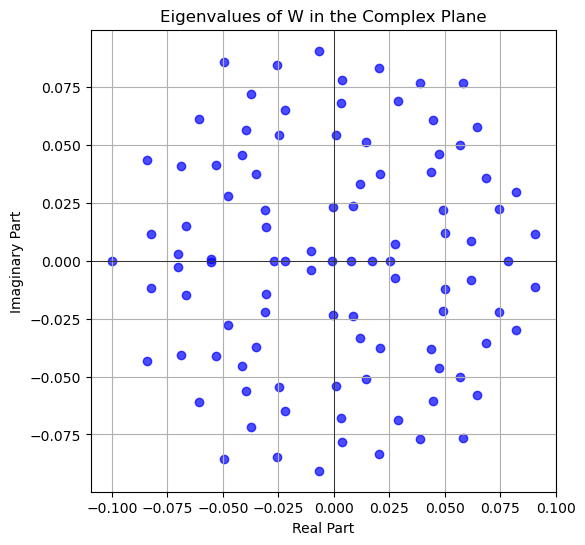

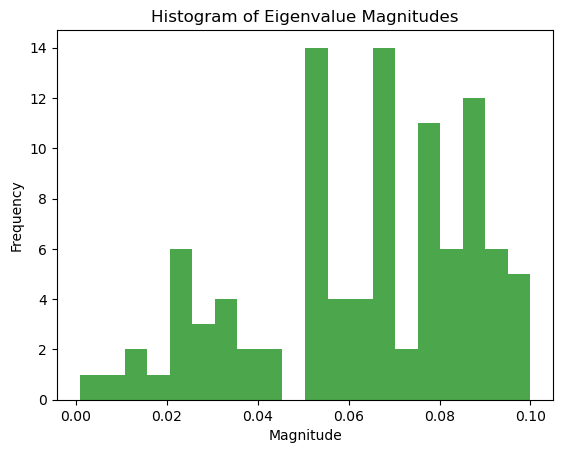

Plots saved to:
/Users/mikel/Documents/GitHub/polimikel/UCR/Weight_matrices/neg_pos/matrix_seed_42_uniform_20250313_091411/rho0x1/eigenvalues_complex_plane.png
/Users/mikel/Documents/GitHub/polimikel/UCR/Weight_matrices/neg_pos/matrix_seed_42_uniform_20250313_091411/rho0x1/eigenvalues_magnitude_histogram.png


In [11]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# -------------------------------
# Configure the file path
# -------------------------------
# Replace with the full path to your .npy file containing the matrix W.
file_path = "/Users/mikel/Documents/GitHub/polimikel/UCR/Weight_matrices/neg_pos/matrix_seed_42_uniform_20250313_091411/rho0x1/W_rescaled_rho0.1.npy"

# -------------------------------
# Load the matrix from the file based on its extension
# -------------------------------
if file_path.endswith('.npy'):
    # Load from a NumPy binary file
    W_np = np.load(file_path)
    W = torch.tensor(W_np)
elif file_path.endswith('.py'):
    import importlib.util
    spec = importlib.util.spec_from_file_location("loaded_module", file_path)
    if spec is None or spec.loader is None:
        raise FileNotFoundError(f"Could not load the module from file path: {file_path}.")
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    if not hasattr(mod, "W"):
        raise AttributeError("The module does not contain an attribute named 'W'.")
    W = mod.W
else:
    raise ValueError("Unsupported file extension. Please use a .npy or .py file.")

# -------------------------------
# Compute Eigenvalues: lambda = a + i*b where a = real part, b = imaginary part
# -------------------------------
eigenvalues = torch.linalg.eigvals(W)
eigenvalues_np = eigenvalues.detach().cpu().numpy()

# Get the directory where the file is located
dir_path = os.path.dirname(file_path)

# -------------------------------
# Plot 1: Eigenvalues in the Complex Plane
# -------------------------------
plt.figure(figsize=(6,6))
plt.scatter(eigenvalues_np.real, eigenvalues_np.imag, color='blue', alpha=0.7)
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Eigenvalues of W in the Complex Plane")
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Save the complex plane plot
plot1_path = os.path.join(dir_path, "eigenvalues_complex_plane.png")
plt.savefig(plot1_path)
plt.show()

# -------------------------------
# Plot 2: Histogram of Eigenvalue Magnitudes, so we be plotting |lambda| = sqrt(a^2 + b^2)
# -------------------------------
magnitudes = np.abs(eigenvalues_np)
plt.figure()
plt.hist(magnitudes, bins=20, color='green', alpha=0.7)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("Histogram of Eigenvalue Magnitudes")

# Save the histogram plot
plot2_path = os.path.join(dir_path, "eigenvalues_magnitude_histogram.png")
plt.savefig(plot2_path)
plt.show()

print(f"Plots saved to:\n{plot1_path}\n{plot2_path}")